# Система поиска подходящих товаров на основе дообученной CLIP-модели

Цели:
1. Дообучить модель CLIP на датасете товаров из магазинов одежды.
2. Реализовать систему поиска изображений товаров по текстовым запросам.

### EDA

Цель — загрузить датасет с Kaggle и исследовать его особенности.

Скачаем датасет на диск.

In [1]:
import kagglehub
from pathlib import Path

dataset_path = Path(kagglehub.dataset_download('nirmalsankalana/fashion-product-text-images-dataset'))

Загрузим датасет в DataFrame, уберём строки с отсутствующими данными и добавим колонку с путём к файлу для каждой
картинки.

In [2]:
import pandas as pd

image_paths = {path.name: str(path) for path in dataset_path.glob('data/*.JPG')}
image_df = pd.read_csv(dataset_path / 'data.csv', usecols=['image', 'description'], index_col='image').dropna()
image_df = image_df.join(pd.Series(image_paths, name='path'), how='inner')
image_df

,description,path
3238.jpg,"Round toed, black sports shoes with red accent...",C:\Users\nygov\.cache\kagglehub\datasets\nirma...
43044.jpg,Style Note Built with the breathability and ze...,C:\Users\nygov\.cache\kagglehub\datasets\nirma...
54018.jpg,Teal handbag that has stitch detailing with a...,C:\Users\nygov\.cache\kagglehub\datasets\nirma...
8141.jpg,"Perfectly stylish, this fastrack analog wrist ...",C:\Users\nygov\.cache\kagglehub\datasets\nirma...
22245.jpg,These id mid-top chukka shoes add a fresh spin...,C:\Users\nygov\.cache\kagglehub\datasets\nirma...
...,...,...
24526.jpg,"Composition Red shirt made of 100% cotton, has...",C:\Users\nygov\.cache\kagglehub\datasets\nirma...
26493.jpg,Composition White round neck T-shirt made of 1...,C:\Users\nygov\.cache\kagglehub\datasets\nirma...
41005.jpg,Style Note denim skirt for your little girl fr...,C:\Users\nygov\.cache\kagglehub\datasets\nirma...
42921.jpg,Style Note This season's french connection lin...,C:\Users\nygov\.cache\kagglehub\datasets\nirma...


Убедимся, что в датасете отсутствуют дубликаты.

In [3]:
image_df.index.duplicated().any()

np.False_

Выведем несколько картинок с описаниями.

1. Black flip flops with thong style fabric straps in brown and a fabric toe separator Printed branding on the footbed TPU outsole with wave patterned grooves
2. Composition Red scoop neck t-shirt made of 100% cotton, with graphic print on the front Wash care 1. Wash dark colours separately 2. Use mild detergent in warm water (maximum 40 degrees) 3. Do not wring or bleach 4. Flat dry in shade 5. Do not iron on print Fitting Regular Fit It is time to indulge in sweet thoughts and wish peace on earth with this red tee from jealous 21. The graphic of the girl in the front with the "Peace" banner with the horns and the "Angel" signature with the pointy tail all have bits of the devil in it - just to show that all good girls have a bit of the bad girl in them. Team this with faded jeans, shorts or a super cute denim mini skirt and stylish footwear from myntra's wide catalogue for that instant cool. Model's statistics 1. The model wears size M in t-shirts 2. Height-5.8", Chest-33"
3. Blue, w

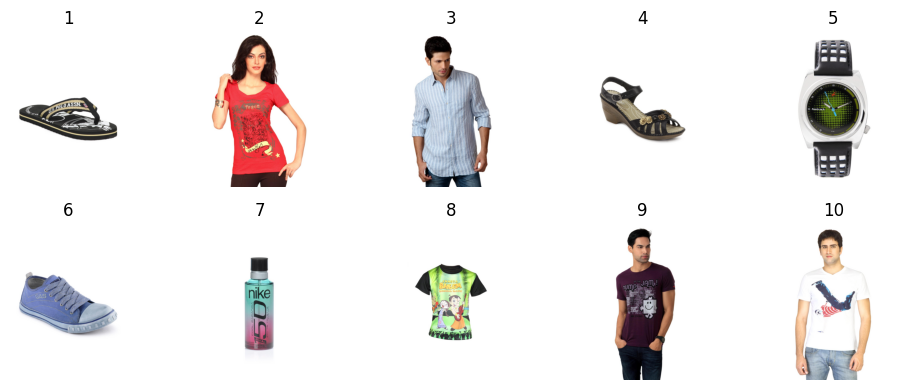

In [4]:
import matplotlib.pyplot as plt
import PIL
import math

image_df_sample = image_df.sample(10, random_state=42)

for i, description in enumerate(image_df_sample.description, start=1):
    print(f'{i}. {description}')

def show_images(image_paths, n_columns=5, scale=2):
    n_rows = math.ceil(len(image_paths) / n_columns)
    plt.figure(figsize=(n_columns * scale, n_rows * scale))
    for i, image_path in enumerate(image_paths, start=1):
        image = PIL.Image.open(image_path).convert('RGB')
        ax = plt.subplot(n_rows, n_columns, i)
        ax.imshow(image)
        ax.set_title(f'{i}', fontsize=12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


show_images(image_df_sample.path)

Можно видеть, что описания достаточно подробные и точно соответствуют картинкам.
При этом в некоторых описаниях присутствует лишняя информация, например, рекомендации по стирке.

Построим распределение длин описаний.

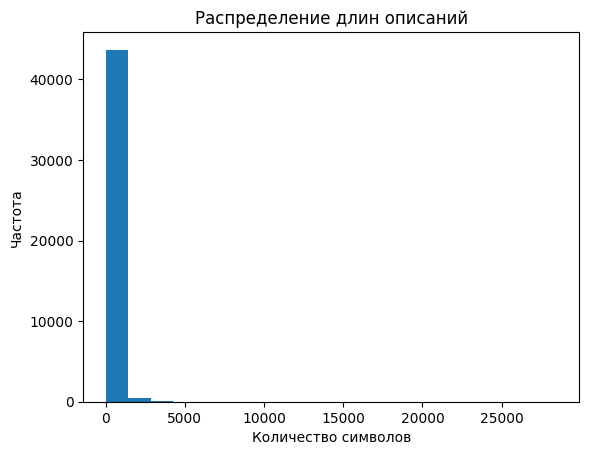

In [5]:
description_lengths = image_df.description.map(len)
description_lengths.plot.hist(
    bins=20,
    xlabel='Количество символов',
    ylabel='Частота',
    title='Распределение длин описаний',
);

Гистограмма получилась неинформативной из-за наличия больших выбросов.
Уберём из выборки верхний и нижний процентили и построим гистограмму ещё раз.

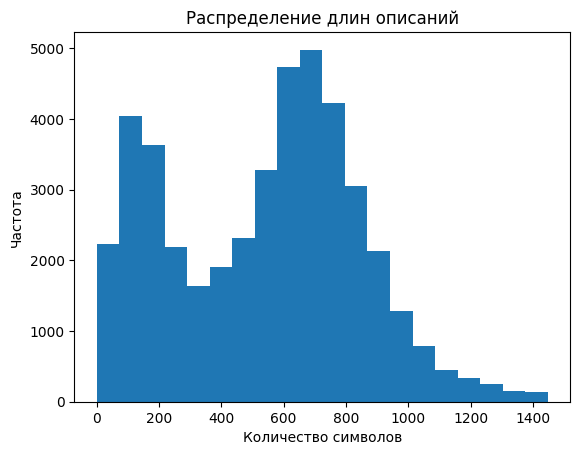

In [6]:
a = description_lengths.quantile(0.01)
b = description_lengths.quantile(0.99)
description_lengths[description_lengths.between(a, b)].plot.hist(
    bins=20,
    xlabel='Количество символов',
    ylabel='Частота',
    title='Распределение длин описаний',
);

Посмотрим характеристики распределения.

In [7]:
description_lengths.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
description,44160.0,555.557767,381.63622,1.0,254.0,593.0,761.0,28466.0


У CLIP контекстное окно ограничено 77 токенами.
Если предположить, что средняя длина токена — 4 символа, то получается, что будут обрезаны все тексты длиннее 308
символов, то есть больше половины.
Скорее всего, это не будет проблемой, потому что обычно суть товара описывается в начале текста, а далее следуют
подробности.

Но можно предложить несколько способов обхода этого ограничения:
1. Разбить текст на предложения и отфильтровать неинформативные предложения с помощью BERT-подобного классификатора.
   При таком подходе могут возникнуть трудности, поскольку не во всех текстах предложения разделены точкой.
2. Попросить LLM извлечь из текста краткую суть товара.
3. Разбить текст на чанки длиной 77 токенов, отправить каждый из них в энкодер, а затем усреднить эмбеддинги по всем
   чанкам.

Загрузим выборку из 1000 изображений и посмотрим, какие разрешения у них встречаются.

In [8]:
image_size_data = []
for image_path in image_df.path.sample(1000, random_state=42):
    image = PIL.Image.open(image_path)
    image_size_data.append(image.size)

pd.DataFrame(image_size_data, columns=['width', 'height']).value_counts().to_frame().head()

,,count
width,height,
1080,1440,1000


Все изображения имеют разрешение 1080 на 1440.

## Подготовка данных

Цели:
* удалить из датасета неинформативные примеры;
* нормализовать данные;
* подготовить датасет для подачи в модель.

В разделе EDA мы видели, что минимальная длина описания — один символ, то есть в датасете присутствуют неадекватно
короткие описания.
Посмотрим, как они выглядят.
Для этого реализуем функцию, которая будет выводить выборку из описаний, длина которых лежит в указанных границах.

In [ ]:
def show_descriptions(min_length=0, max_length=float('inf'), n=10, seed=None, max_display_length=None):
    description_lengths = image_df.description.map(len)
    descriptions = image_df.description[description_lengths.between(min_length, max_length)]
    print(f'Найдено описаний длиной от {min_length} до {max_length} символов: {len(descriptions)} шт.')
    if not descriptions.empty:
        print('Примеры:')
        for description in descriptions.sample(n, random_state=seed):
            if max_display_length is not None:
                description = description[:max_display_length]
            print(f'  • {description}')

show_descriptions(1, 10, seed=42)

Найдено описаний длиной от 1 до 10 символов: 1060 шт.
Примеры:
  • -
  • -
  • -
  • -
  • -
  • -
  • -
  • -
  • -
  • -


: 

In [10]:
show_descriptions(11, 20, seed=42)

Найдено описаний длиной от 11 до 20 символов: 65 шт.
Примеры:
  • Warranty : 2 Years
  • Style Description
  •  Style Note
  • Style Description
  • Style Note  Check
  • Style Description
  • Style Description
  • asfafaf kasjhdkashd
  • Flat sandals
  • Style Note  Check


In [11]:
show_descriptions(21, 30, seed=42)

Найдено описаний длиной от 21 до 30 символов: 50 шт.
Примеры:
  • Style Note  Created for
  • Navy blue polo tshirt.
  • Pink striped polo tshirt.
  • Playboy Vegas 24h Deo
  • Blue aerosol spray can
  • Green striped polo tshirt.
  •  Style Note  Girls love < 
  • Style Note Girls love <
  • Black sari with green accents
  •  Style Note  Girls love < 


In [12]:
show_descriptions(31, 40, seed=42)

Найдено описаний длиной от 31 до 40 символов: 49 шт.
Примеры:
  • Cream dupatta with a crushed look
  • Blue glass bottle, silver coloured cap
  • Magenta dupatta with a crushed look
  • Moss green saree with screen print
  • Blue sari with blue and red floral print
  • All DRY WEATHER outdoor activities.
  • Style Note Girls love shoes, whether
  • Pink and grey sari with beige print
  • Grey and maroon sari with green accents
  • Pack of two, (Buy 1 get 1 free)


Видно, что в границах 21-30 символов начинают появляться осмысленные описания, а в границах 31-40 символов уже почти все
описания являются осмысленными.
Поэтому уберём из датасета все записи с описаниями короче 30 символов. 

In [13]:
image_df = image_df[description_lengths >= 30].copy()

Теперь посмотрим, что представляют из себя выбросы с очень длинными описаниями.

In [14]:
show_descriptions(2000, float('inf'), seed=42, max_display_length=100)

Найдено описаний длиной от 2000 до inf символов: 125 шт.
Примеры:
  • Originally designed as a cross training shoe, the nike Air Max Trainer Excel has become a big time f
  • FLY HIGH ON THE Basketball COURT  Sleek and stylish, the adidas Tip Off is a great basketball shoe t
  • WHERE STYLE MEETS PERFORMANCE The latest edition of the reebok HexRide, the HexRide Crussion stands 
  • Replete with a rugged heel and seamless mesh, this well cushioned adiSTAR Ride 3 running shoe for me
  •       Style Note  Inspired from India's rich jewel history, this pair of earrings from royal diadem 
  • opium eyewear is a range of addictive sunglasses stylised for international fashions and incorporati
  • ????????????????????????????????????????????????????????????????????????????????????????????????????
  • A FORCE TO RECKON WITH Versatility and lightweight comfort rolled into one brings the adidas titan B
  • Originally designed for boaters and  fishermen to have a firm foot  even on slippery surfa

Большинство текстов являются осмысленными, поэтому не будем их трогать.

На примерах выше было видно, что тексты являются достаточно грязными.
Попробуем это исправить: нормализуем пробелы между словами и уберём пробелы в начале текста.
После этого выведем несколько примеров, чтобы оценить результат.

In [15]:
import re

def clean_text(text: str):
    return re.sub(r'\s+', ' ', text).strip()

image_df.description = image_df.description.map(clean_text)
show_descriptions(max_display_length=100, seed=42)

Найдено описаний длиной от 0 до inf символов: 42986 шт.
Примеры:
  • Style Note This beautifully toned pair from catwalk are great to tone down a blingy ensemble or clas
  • These high-top rustic shoes from buckaroo blend vintage cowboy styling with a contemporary minimal t
  • Let monsoon pave the way for your style with these fun-to-wear-in-the-rains flip flops from nike. Up
  • Style Note This kurta by diva is designed to accentuate your femininity, combining traditional print
  • A love-forever classic, this murcia bag is a closet essential. Perfect for colour blocking and mix-a
  • Composition White round neck t-shirt, made of 100% polyester, engineered with Dri-Fit technology, ha
  • Composition Moss green woven mandarin neck T-shirt made of 100% cotton, has short sleeves with ribbe
  • Style Note When the whole world is going environmentally-friendly, be it with recycling, planting tr
  • Composition Blue jeans with a washed look made of 66% cotton and 34% polyester, has a flat 

Удалим из датасета описания, в которых нет ни одной буквы.

In [16]:
def is_normal_text(text: str):
    return any(character.isalpha() for character in text)

normal_text_mask = image_df.description.map(is_normal_text)
image_df = image_df[normal_text_mask].copy()
print(f'Удалено записей: {(~normal_text_mask).sum()}.')

Удалено записей: 0.


Преобразуем `DataFrame` в `Dataset` и разделим его на части для тренировки и тестирования.

In [17]:
from datasets import Dataset, Features, Value, Image

ds = Dataset.from_pandas(
    image_df.rename(columns={'path': 'image'}),
    features=Features({'image': Image(), 'description': Value('string')}),
    preserve_index=False,
).train_test_split(test_size=0.1, shuffle=True, seed=42)
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'description'],
        num_rows: 38687
    })
    test: Dataset({
        features: ['image', 'description'],
        num_rows: 4299
    })
})

Посмотрим, как выглядит запись датасета.

In [18]:
ds['test'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440>,
 'description': "Style Note A hard-wearing T-shirt from Gini and Jony just like his dad's. A wear-everywhere style in comfy cotton that he'll love playing in. Dress him up with a pair of denims and he'll look just like the little man he's going to grow up to be. Product Details Green round neck T-shirt, has short sleeves and print and appliqué work on the chest Material and Care 100% cotton Machine wash separately in cold water using a mild detergent Do not bleach or soak Line dry inside out in shade Warm iron only Do not iron directly on print/embroidery"}

## CLIP-модель

Загрузим CLIP-модель.
Подадим в неё первые 10 элементов из датасета и визуализируем полученные логиты.

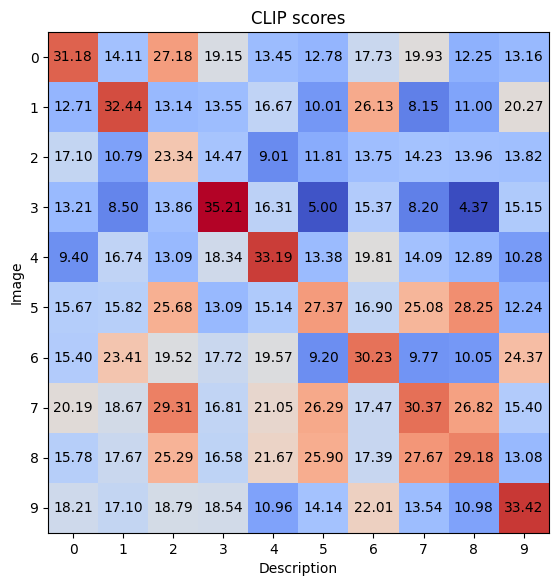

In [ ]:
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel

model_name = 'openai/clip-vit-base-patch32'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = CLIPProcessor.from_pretrained(model_name, use_fast=True)
model = CLIPModel.from_pretrained(model_name).to(device)

def encode_batch(batch):
    encoded = processor(
        images=[item['image'] for item in batch],
        text=[item['description'] for item in batch],
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    encoded['return_loss'] = True
    return encoded

with torch.no_grad():
    batch = encode_batch(ds['test'].select(range(10)))
    batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    output = model(**batch)
    clip_scores = output.logits_per_image.numpy(force=True)

plt.figure(figsize=(6.5, 6.5))
plt.title('CLIP scores')
plt.imshow(clip_scores, cmap='coolwarm')
plt.xticks(np.arange(clip_scores.shape[1]), labels=np.arange(clip_scores.shape[1]))
plt.yticks(np.arange(clip_scores.shape[0]), labels=np.arange(clip_scores.shape[0]))
plt.xlabel('Description')
plt.ylabel('Image')

for i in range(clip_scores.shape[0]):
    for j in range(clip_scores.shape[1]):
        plt.text(j, i, f'{clip_scores[i, j]:.2f}', ha='center', va='center', color='black')

Можно видеть, что в матрице преобладают диагональные элементы — это значит, что наибольшее сходство обнаруживается
между эмбеддингами изображений и текстовых описаний одних и тех же объектов.
Далее мы будем отслеживать, как меняются значения этих диагональных элементов в процессе обучения модели. 

## Fine-tuning

Цель — дообучить модель на полученном датасете.

Запустим цикл дообучения модели.
В конце каждой эпохи будем логировать среднее значение CLIP score и его стандартное отклонение.

In [20]:
from transformers import Trainer, TrainingArguments

def compute_metrics(eval_pred):
    logits = eval_pred.predictions[0]  # logits per image (concatenated batches)
    batch_size = logits.shape[1]
    logit_batches = [logits[i:i+batch_size] for i in range(0, logits.shape[0], batch_size)]
    clip_scores = np.concat([logit_batch.diagonal() for logit_batch in logit_batches])
    return {'clip_score_mean': clip_scores.mean(), 'clip_score_std': clip_scores.std()}

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        num_train_epochs=10,
        learning_rate=5e-5,
        output_dir='checkpoints',
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        logging_strategy='steps',
        logging_steps=1,
        logging_first_step=True,
        eval_strategy='epoch',
        eval_on_start=True,
        save_strategy='epoch',
        save_total_limit=2,
        remove_unused_columns=False,
    ),
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    data_collator=encode_batch,
    compute_metrics=compute_metrics,
)
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Clip Score Mean,Clip Score Std
0,No log,1.023480,30.203253,3.145005
1,0.443300,0.536689,30.606544,2.395355
2,0.097500,0.415101,33.304035,2.569769
3,0.175100,0.399627,33.932877,2.776456
4,0.027300,0.365632,36.753281,3.085191
5,0.011500,0.347616,36.599911,3.111289
6,0.017100,0.322461,38.193691,3.296494
7,0.229200,0.285700,39.439629,3.551360
8,0.049200,0.278177,40.252361,3.805505
9,0.000400,0.277396,42.094166,4.172674


Визуализируем, как менялась ошибка в процессе обучения.

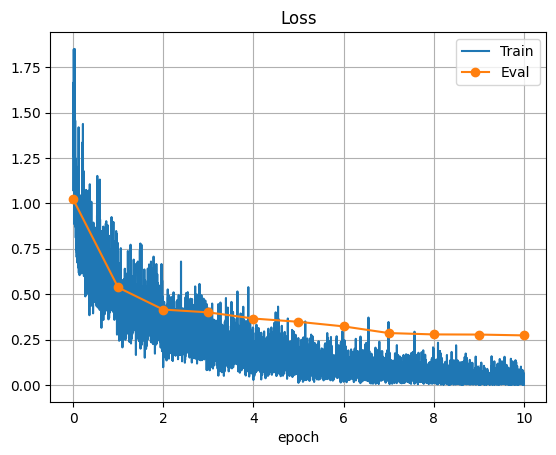

In [21]:
train_log_df = pd.DataFrame(trainer.state.log_history)
eval_log_df = train_log_df.dropna(subset='eval_loss').copy()
train_log_df.dropna(subset='loss', inplace=True)
plt.title('Loss')
plt.plot(train_log_df.epoch, train_log_df.loss, label='Train')
plt.plot(eval_log_df.epoch, eval_log_df.eval_loss, marker='o', label='Eval')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

Визуализируем, как менялись значения CLIP-score в процессе обучения.
Нанесём на график среднее значение и границы интервала "3 сигма".

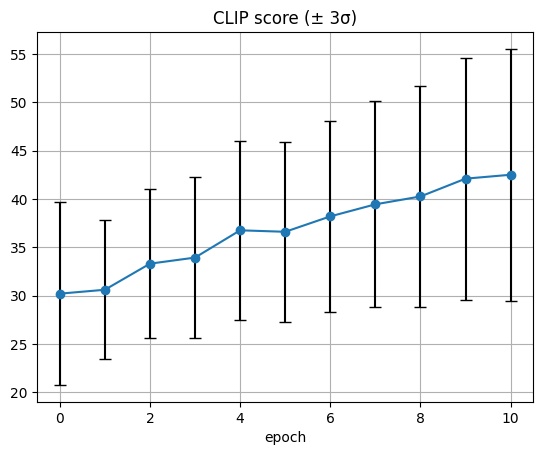

In [23]:
eval_log_df['eval_clip_score_range'] = 3 * eval_log_df.eval_clip_score_std
axes = eval_log_df.plot(
    x='epoch',
    y='eval_clip_score_mean',
    yerr='eval_clip_score_range',
    ecolor='black',
    capsize=4,
    marker='o',
    grid=True,
    legend=False,
    title='CLIP score (± 3σ)'
)

## Система поиска товаров

Цель — реализовать поисковую систему, способную принимать текстовые запросы и возвращать наиболее релевантные
изображения из датасета.
Система должна работать эффективно, то есть не пересчитывать каждый раз векторные представления картинок.

Будем реализовывать поисковую систему в виде класса с интерфейсом из двух основных методов:

1. `add_images` — добавление изображений в систему.
2. `__call__` — поиск $k$ наиболее подходящих изображений по текстовому описанию.

Для реализации поиска $k$ ближайших векторов воспользуемся FAISS.

Реализуем класс поисковой системы.
Создадим его экземпляр и добавим в него все изображения из датасета.

In [ ]:
import faiss
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

class ImageRetriever:
    def __init__(self, processor, model, index=None):
        self.processor = processor
        self.model = model
        self.index = index
        self.image_paths = np.empty(0, dtype='O')

    @torch.no_grad
    def add_images(self, image_paths):
        image_paths = np.array(image_paths)
        if len(image_paths) == 0:
            return
        ds = Dataset.from_dict({'image': image_paths}, features=Features({'image': Image()}))
        data_loader = DataLoader(ds, batch_size=64, collate_fn=self._encode_batch)
        embedding_batches = []
        for batch in tqdm(data_loader, desc='Generating image embeddings'):
            embedding_batches.append(model.get_image_features(batch['pixel_values'].to(device)).numpy(force=True))
        embeddings = np.vstack(embedding_batches)
        embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)
        if self.index is None:
            self.index = faiss.IndexFlatIP(embeddings.shape[1])
        self.index.add(embeddings)
        self.image_paths = np.concatenate([self.image_paths, image_paths])

    def __call__(self, query, k=5):
        inputs = self.processor(
            text=query,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).to(device)
        text_embedding = model.get_text_features(**inputs).numpy(force=True)
        _, indices = self.index.search(text_embedding, k)
        image_paths = self.image_paths[indices]
        # Возвращаем массив формы (k), если передан один запрос, и (n, k), если передана коллекция из n запросов.
        return image_paths[0] if isinstance(query, str) else image_paths

    def _encode_batch(self, batch):
        return self.processor(
            images=[item['image'] for item in batch],
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

image_retriever = ImageRetriever(processor, model)
image_retriever.add_images(image_df.path)

Generating image embeddings:   0%|          | 0/672 [00:00<?, ?it/s]

Опробуем различные поисковые запросы, выводя топ-5 наиболее подходящих найденных изображений.

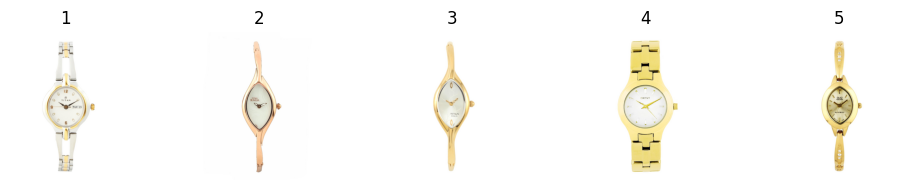

In [25]:
show_images(image_retriever('Thin golden watch', 5))

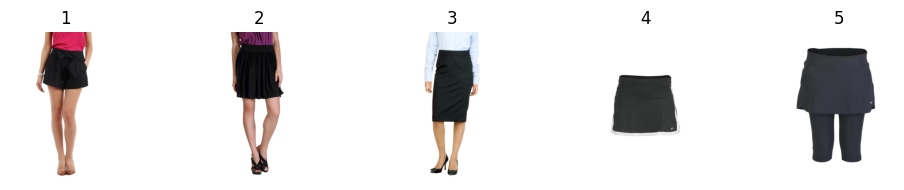

In [26]:
show_images(image_retriever('Black office skirt', 5))

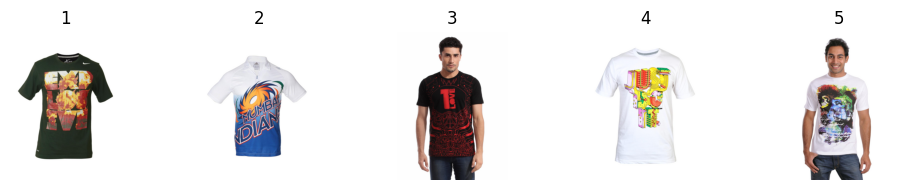

In [27]:
show_images(image_retriever('T-shirt with a colorful print for men', 5))

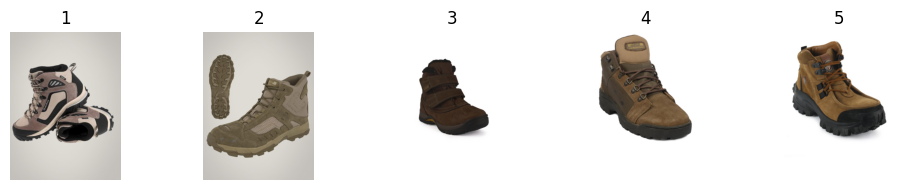

In [28]:
show_images(image_retriever('Hiking boots', 5))

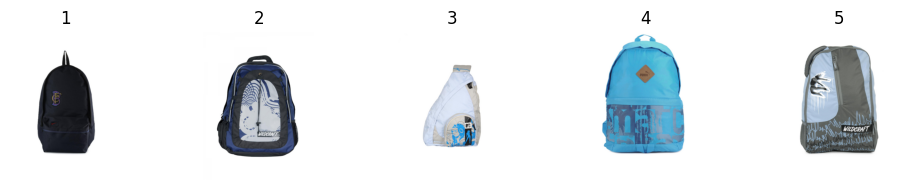

In [29]:
show_images(image_retriever('School bag', 5))

## Вывод

* CLIP-модель была дообучена на  датасете с изображениями и текстовыми описаниями элементов одежды.
* На основе полученной CLIP-модели была реализована поисковая система, выдающая наиболее релевантные изображения по
  текстовому описанию.
* Поисковая система была протестирована на различных запросах.
  Изображения, выдаваемые системой, показали хорошее соответствие текстам запросов. 